# TP Laboratorio de Implementación 2 - Preprocesamiento Avanzado

# PetFinder.my – Pre‑processing Notebook

A continuación tienes un texto listo para copiar‑pegar en una celda Markdown del notebook (idealmente la primera, antes de cualquier código).
Describe, paso a paso, los 10 bloques del cuaderno de pre‑procesamiento, de modo que cualquier lector entienda qué hace cada celda y por qué es necesaria.

⸻

## Guía de lectura del notebook de pre‑procesamiento (petfinder_preprocessing.ipynb)

### Objetivo general

Limpiar y transformar el archivo train.csv de la competencia PetFinder.my Adoption Prediction para que las variables queden listas para entrenar un modelo LightGBM, conservando la reproducibilidad del pipeline.

|#	|Bloque de código	|¿Qué hace?	|¿Por qué es importante?|
|---|-------------------|-----------|-----------------------|
|1	|Encabezado Markdown	|Presenta el título del notebook, la fecha de generación y una breve descripción del flujo de trabajo.	|Documenta el propósito y la “foto” temporal del experimento; facilita la colaboración. |
|2	|Imports y configuración global	|Carga las librerías (pandas, numpy, sklearn, joblib, etc.).- Define DATA_PATH con la ruta al archivo train.csv.	|Centraliza dependencias y evita errores de importación dispersos. DATA_PATH es el único lugar que hay que tocar si cambias la ubicación del dataset.1 |
|3	|Carga de datos	- Lee train.csv en un DataFrame.- Imprime la forma (filas × columnas).- Muestra las primeras 5 filas.	|Verifica rápidamente que el archivo existe, se lee bien y las columnas lucen razonables antes de invertir tiempo en transformaciones. |
|4	|Inspección rápida (df.info)	|Ejecuta df.info(show_counts=True) para listar:• Tipo de dato de cada columna.• Nº de valores no‑nulos.• Memoria usada.	|Permite detectar columnas mal tipadas (p. ej. números que llegan como strings) y cuantificar valores faltantes, lo que influye en la estrategia de imputación. |
|5	|Identificación de columnas numéricas y categóricas	|Crea numeric_cols con todas las columnas int64 / float64.- Crea categorical_cols con las columnas object.- Imprime ambas listas.	|Estas listas alimentan el ColumnTransformer que aplicará pipelines distintos según el tipo de dato; evita “hard‑codear” nombres y mantiene el notebook genérico. |
|6	|Funciones globales picklables	|Define dos funciones:• numeric_clip_log → log1p a Fee + clipping de Age a 120 meses.• cat_to_int → convierte cada categórica a códigos enteros (cat.codes).	|Al estar a nivel de módulo, son serializables con joblib. Encapsulan reglas de negocio (sesgo de Fee, valores aberrantes en Age, codificación para LightGBM). |
|7	|Agrupador de categorías raras	|Función rare_label_encoder + FunctionTransformer que:- Calcula la frecuencia relativa de cada categoría.- Reemplaza las que aparecen en < 1 % de los registros por "__RARE__".	|Reduce cardinalidad y ruido, evita que LightGBM cree nodos con muy pocos ejemplos y mitiga overfitting. |
|8	|Construcción del ColumnTransformer (preprocessor) |numeric_pipeline: numeric_clip_log → imputación mediana + indicador de nulos.- categorical_pipeline: agrupador de raros → cat_to_int.- Combina ambos en preprocessor, descartando (remainder='drop') cualquier columna no listada.	|Concentra todas las transformaciones en un objeto serializable y reproducible. El indicador de nulos permite que el modelo aprenda si “no informar” es informativo. |
|9	|Ajuste (fit) y transformación	|fit_transform sobre todo el DataFrame.- Obtiene nombres de las columnas resultantes (get_feature_names_out).- Reconstruye processed_df con nombres legibles.- Muestra forma y primeras filas.	|Verifica que la transformación funciona, que el número de columnas coincide con lo esperado y que no hay errores de tipado. |
|10	|Guardado de artefactos	|Guarda processed_df en Parquet (train_preprocessed.parquet).- Serializa el preprocessor con joblib.dump() (preprocessor.joblib).	|Parquet conserva tipos y es compacto; el pipeline serializado garantiza que las mismas reglas se apliquen a test.csv o a datos en producción, evitando inconsistencias. |



⸻

#### Notas adicionales
- Si solo necesitas el dataset limpio para un experimento puntual, puedes omitir el joblib.dump().
- Si vas a validar en K‑Fold, predecir sobre test.csv o desplegar en producción, mantén el pipeline: te ahorrará bugs de desalineación de medianas, categorías raras o cat.codes.
- Para acelerar I/O en notebooks grandes, cambia CSV → Parquet/Feather y deja CSV solo para entregas manuales.

Con esta guía insertada al inicio del cuaderno, cualquier persona (incluido tu “yo” del futuro) sabrá exactamente qué hace cada celda y podrá modificarla sin miedo.

#### Cómo extender o modificar

|Necesidad	|Qué tocar |
|-----------|----------|
|Cambiar el umbral de rareza	|threshold en rare_label_encoder (línea correspondiente). |
|Usar media en vez de mediana	|SimpleImputer(strategy='mean', add_indicator=True). |
|Aplicar log1p a otra variable	|Añadirla dentro de _transform en el bloque 6. |
|Mantener columnas sin procesar	|En ColumnTransformer, usa remainder='passthrough' en lugar de 'drop'. |
|One‑hot en vez de cat.codes	|Reemplazar cat_to_int por OneHotEncoder(handle_unknown='ignore'). |

Con este desglose, cada bloque debería resultar claro y, sobre todo, fácil de adaptar a nuevas reglas de negocio o a cambios en el dataset.

In [ ]:
# pip install pingouin

## Librerias y Funciones Definidas

In [1]:
# Importamos libreriastioSpeed
import os
# os.environ["MKL_DEBUG_CPU_Vaccinated"] = "5"
# os.chdir('/Users/ri1965/Desktop/Maestria DS Austral 2024/11 - Labo 02/petfinder-adoption-prediction/train')

# Carga de Librerias
# Generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Procesamiento de palabras
from wordcloud import WordCloud, STOPWORDS

# Scipy
import scipy.stats as stats
from scipy.stats import shapiro, normaltest, anderson
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from scipy.stats import kruskal

# Statsmodels
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import statsmodels.formula.api as smf

# Pingouin
import pingouin as pg

In [2]:
# Función para mostrar todos los gráficos de distribución para una variable
def graficos_distribucion(df, variable):
    plt.figure(figsize=(15, 4))

    # Histograma + KDE
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], kde=True)
    plt.title(f"Histograma de {variable}")
    plt.xlabel(variable)
    plt.ylabel("Frecuencia")

    # Boxplot
    plt.subplot(1, 3, 2)
    sns.boxplot(y=df[variable])
    plt.title(f"Boxplot de {variable}")
    plt.xlabel(variable)

    # QQ Plot
    plt.subplot(1, 3, 3)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.title(f"QQ Plot de {variable}")

    plt.tight_layout()
    plt.show()

/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
# Función para aplicar distintos tests de normalidad y graficar
def analizar_normalidad(df, variable):
    print(f"\n--- Normalidad para {variable} ---")

    # Shapiro-Wilk Test
    stat, p = shapiro(df[variable])
    print(f"Shapiro-Wilk: W={stat:.4f}, p={p:.4f} {'-> No normal' if p < 0.05 else '-> Normal'}")
    
    # D'Agostino and Pearson's test
    stat, p = normaltest(df[variable])
    print(f"D’Agostino-Pearson: stat={stat:.4f}, p={p:.4f} {'-> No normal' if p < 0.05 else '-> Normal'}")

    # Anderson-Darling Test
    result = anderson(df[variable])
    print(f"Anderson-Darling: A={result.statistic:.4f}")
    for i in range(len(result.critical_values)):
        sig = result.significance_level[i]
        crit = result.critical_values[i]
        print(f"  Nivel {sig}%: crítico={crit:.4f} {'-> No normal' if result.statistic > crit else '-> Normal'}")


In [4]:
def numeric_clip_log(X: pd.DataFrame) -> pd.DataFrame:
    """Aplica log1p a Fee y recorta Age a 120 meses."""
    X = X.copy()
    if 'Fee' in X.columns:
        X['Fee'] = np.log1p(X['Fee'])
    if 'Age' in X.columns:
        X['Age'] = X['Age'].clip(upper=120)
    return X

def cat_to_int(X: pd.DataFrame) -> pd.DataFrame:
    """Convierte cada columna categórica a códigos enteros consecutivos."""
    return X.apply(lambda col: col.astype('category').cat.codes)

## Carga de Datos

In [5]:
# Carga de .csv
df = pd.read_csv('train.csv')
df_breed_labels = pd.read_csv('breed_labels.csv')
df_color_labels = pd.read_csv('color_labels.csv')
df_state_labels = pd.read_csv('state_labels.csv')


In [6]:
# Inspección de los datos
df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13728 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14993 non-null  int64  
 18  Rescue

In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import joblib

In [9]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

In [10]:
def numeric_transform():
    def _transform(X):
        X = X.copy()
        if 'Fee' in X.columns:
            X['Fee'] = np.log1p(X['Fee'])      # log1p para reducir sesgo
        if 'Age' in X.columns:
            X['Age'] = X['Age'].clip(upper=120) # recorte a 120 meses
        return X
    return FunctionTransformer(_transform, feature_names_out='one-to-one')

- FunctionTransformer permite meter lógica “a mano” dentro del Pipeline.
- log1p evita problemas de log(0).
- clip protege de valores aberrantes de edad.


In [11]:
def rare_label_encoder(X, threshold=0.01):
    X = X.copy()
    for col in X.columns:
        freq = X[col].value_counts(normalize=True)
        rare = freq[freq < threshold].index
        X[col] = X[col].where(~X[col].isin(rare), other='__RARE__')
    return X

rare_transformer = FunctionTransformer(
    rare_label_encoder,
    kw_args={'threshold': 0.01},
    feature_names_out='one-to-one'
)

- Recorre cada columna categórica.
- Si una categoría aparece en < 1 % de las filas, la reemplaza por "__RARE__".
- Mantiene la señal sin inflar la cardinalidad.


In [12]:
numeric_pipeline = Pipeline(steps=[
    ('clip_log', FunctionTransformer(
        numeric_clip_log,               #  ← función global
        validate=False,
        feature_names_out='one-to-one')),
    ('imputer', SimpleImputer(strategy='median', add_indicator=True))
])

categorical_pipeline = Pipeline(steps=[
    ('rare', rare_transformer),
    ('cat_to_int', FunctionTransformer(
        cat_to_int,                      #  ← función global
        validate=False,
        feature_names_out='one-to-one'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
], remainder='drop')

Detalles
- SimpleImputer(add_indicator=True) añade columnas extras _missing.
- En categóricas, cat.codes convierte cada categoría a un entero consecutivo (requisito de LightGBM).
- ColumnTransformer aplica cada sub‑pipeline solo a sus columnas.


In [13]:
X_processed = preprocessor.fit_transform(df)
processed_cols = preprocessor.get_feature_names_out()
processed_df = pd.DataFrame(X_processed, columns=processed_cols)

- fit_transform: aprende mediana, categorías, etc. y transforma.
- Se reconstruye un DataFrame legible con los nombres nuevos.


In [17]:
processed_df = pd.concat([processed_df, df['AdoptionSpeed']], axis=1)

In [18]:
processed_df.to_csv('/Users/ri1965/Desktop/Maestria DS Austral 2024/11 - Labo 02/input/petfinder-adoption-prediction/train/train_preprocessed.csv', index=False)

In [19]:
processed_path = Path('/Users/ri1965/Desktop/Maestria DS Austral 2024/11 - Labo 02/input/petfinder-adoption-prediction/train/train_preprocessed.csv')
processed_df.to_csv(processed_path, index=False)
joblib.dump(preprocessor, '/Users/ri1965/Desktop/Maestria DS Austral 2024/11 - Labo 02/input/petfinder-adoption-prediction/train/preprocessor.joblib')

['/Users/ri1965/Desktop/Maestria DS Austral 2024/11 - Labo 02/input/petfinder-adoption-prediction/train/preprocessor.joblib']

In [20]:
processed_path = Path('/Users/ri1965/Desktop/Maestria DS Austral 2024/11 - Labo 02/input/petfinder-adoption-prediction/train/train_preprocessed.parquet')
processed_df.to_parquet(processed_path, index=False)
joblib.dump(preprocessor, '/Users/ri1965/Desktop/Maestria DS Austral 2024/11 - Labo 02/input/petfinder-adoption-prediction/train/preprocessor.joblib')

['/Users/ri1965/Desktop/Maestria DS Austral 2024/11 - Labo 02/input/petfinder-adoption-prediction/train/preprocessor.joblib']

λ óptimo ≈ 0.350


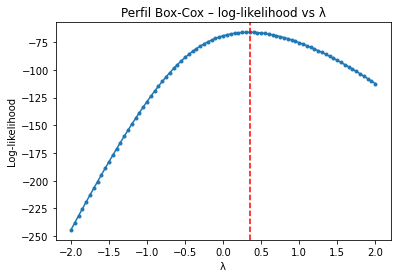

                            OLS Regression Results                            
Dep. Variable:              alerta_bc   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     2.099
Date:                Tue, 15 Apr 2025   Prob (F-statistic):              0.154
Time:                        21:41:56   Log-Likelihood:                -89.356
No. Observations:                  50   AIC:                             182.7
Df Residuals:                      48   BIC:                             186.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7514      0.489      5.625      0.0

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import boxcox_llf, boxcox

# ------------------------------------------------------------------
# 1. Cargar los datos
# ------------------------------------------------------------------
# data = pd.read_csv('mi_archivo.csv')   # si ya lo tienes en disco
# Ejemplo ficticio:
np.random.seed(0)
data = pd.DataFrame({
    "dosis": np.repeat([10, 20, 30, 40, 50], 10),
    "alerta": np.random.gamma(shape=2, scale=3, size=50)   # > 0
})

# ------------------------------------------------------------------
# 2. Definir la grilla de λ y calcular log‑likelihood
# ------------------------------------------------------------------
y = data["alerta"].values
lam_grid = np.linspace(-2, 2, 81)           # igual que MASS por defecto
llf = [boxcox_llf(lmbda, y) for lmbda in lam_grid]
lam_opt = lam_grid[np.argmax(llf)]
print(f"λ óptimo ≈ {lam_opt:.3f}")

# ------------------------------------------------------------------
# 3. Dibujar el perfil de log‑likelihood (equivalente a plotit = TRUE)
# ------------------------------------------------------------------
plt.figure(figsize=(6, 4))
plt.plot(lam_grid, llf, "-o", ms=3)
plt.axvline(lam_opt, color="red", ls="--")
plt.title("Perfil Box‑Cox – log‑likelihood vs λ")
plt.xlabel("λ")
plt.ylabel("Log‑likelihood")
plt.show()

# ------------------------------------------------------------------
# 4. Transformar la respuesta con el λ óptimo
# ------------------------------------------------------------------
y_bc = boxcox(y, lmbda=lam_opt)
data["alerta_bc"] = y_bc

# ------------------------------------------------------------------
# 5. Ajustar el modelo lineal con la respuesta transformada
# ------------------------------------------------------------------
modelo_bc = smf.ols("alerta_bc ~ dosis", data=data).fit()
print(modelo_bc.summary())